In [2]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d453091e1590d24108c45f9940da7654c05c1f15c47d5e74cde82a4bb16879af
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


# SP LIME

## Regression explainer with boston housing prices dataset

In [1]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import sklearn.linear_model
import sklearn.model_selection
import numpy as np
from sklearn.metrics import r2_score
np.random.seed(1)

#load example dataset
boston = load_boston()

#print a description of the variables
print(boston.DESCR)

#train a regressor
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(boston.data, boston.target, train_size=0.80, test_size=0.20)
rf.fit(train, labels_train);

#train a linear regressor
lr = sklearn.linear_model.LinearRegression()
lr.fit(train,labels_train)

#print the R^2 score of the random forest
print("Random Forest R^2 Score: " +str(round(r2_score(rf.predict(test),labels_test),3)))
print("Linear Regression R^2 Score: " +str(round(r2_score(lr.predict(test),labels_test),3)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
# import lime tools
import lime
import lime.lime_tabular

# generate an "explainer" object
categorical_features  = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names, class_names=['price'], categorical_features=categorical_features, verbose=False, mode='regression',discretize_continuous=False)

In [4]:
#generate an explanation
i = 13
exp = explainer.explain_instance(test[i], rf.predict, num_features=14)

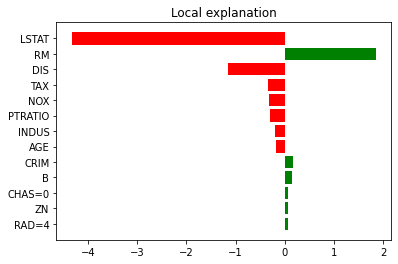

In [5]:
%matplotlib inline
fig = exp.as_pyplot_figure();

In [6]:
print("Input feature names: ")
print(boston.feature_names)
print('\n')

print("Input feature values: ")
print(test[i])
print('\n')

print("Predicted: ")
print(rf.predict(test)[i])

Input feature names: 
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


Input feature values: 
[4.3790e-02 8.0000e+01 3.3700e+00 0.0000e+00 3.9800e-01 5.7870e+00
 3.1100e+01 6.6115e+00 4.0000e+00 3.3700e+02 1.6100e+01 3.9690e+02
 1.0240e+01]


Predicted: 
20.15639999999994


# SP-LIME pick step

### Maximize the 'coverage' function:

$c(V,W,I) = \sum_{j=1}^{d^{\prime}}{\mathbb{1}_{[\exists i \in V : W_{ij}>0]}I_j}$

$W = \text{Explanation Matrix,  } n\times d^{\prime}$

$V = \text{Set of chosen explanations}$

$I = \text{Global feature importance vector,   } I_j = \sqrt{\sum_i{|W_{ij}|}}$

In [7]:
import lime

In [8]:
import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, train, rf.predict, sample_size=20, num_features=14, num_exps_desired=5)

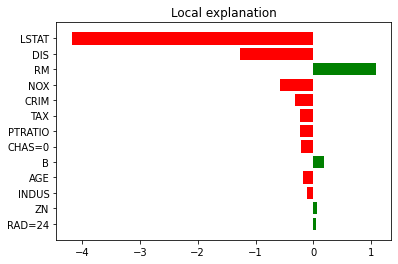

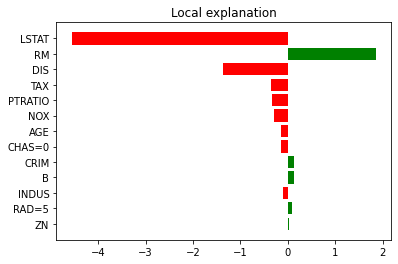

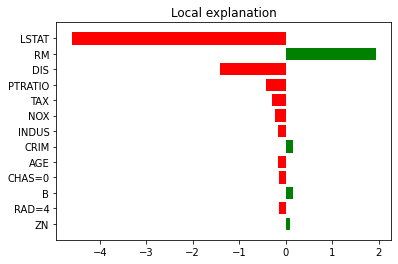

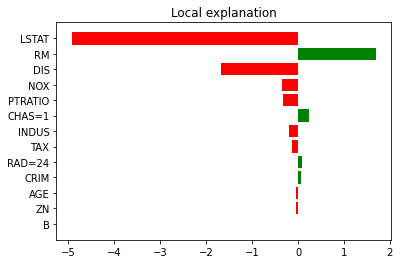

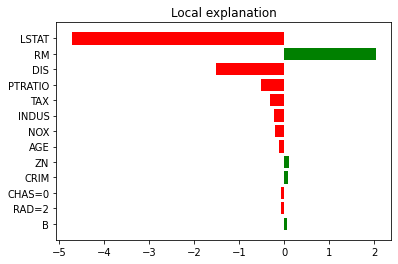

In [9]:
[exp.as_pyplot_figure() for exp in sp_obj.sp_explanations];

In [10]:
import pandas as pd
W=pd.DataFrame([dict(this.as_list()) for this in sp_obj.explanations])

In [11]:
W.head()

,LSTAT,RM,DIS,NOX,PTRATIO,CHAS=1,INDUS,TAX,RAD=24,CRIM,AGE,ZN,B,CHAS=0,RAD=2,RAD=4,RAD=5,RAD=7,RAD=3
0,-4.929416,1.697405,-1.678593,-0.343929,-0.317995,0.248173,-0.189888,-0.125698,0.074646,0.074090,-0.054992,-0.038936,-0.000620,NaN,NaN,NaN,NaN,NaN,NaN
1,-4.731303,2.032500,-1.520662,-0.208115,-0.510754,NaN,-0.233671,-0.319909,NaN,0.089684,-0.121158,0.092807,0.060465,-0.072950,-0.07127,NaN,NaN,NaN,NaN
2,-4.987951,1.391281,-1.447791,-0.492879,-0.310579,NaN,-0.112998,-0.145892,0.150306,0.000885,-0.174304,0.059408,0.044982,0.048810,NaN,NaN,NaN,NaN,NaN
3,-4.395137,2.048636,-1.134122,-0.175195,-0.406137,NaN,-0.113659,-0.287595,NaN,0.217889,-0.178169,-0.029509,0.031312,0.031539,NaN,0.021326,NaN,NaN,NaN
4,-4.781924,1.940944,-1.602665,-0.244220,-0.393323,NaN,-0.150605,-0.357769,NaN,0.276965,-0.110927,0.017758,0.101875,-0.289823,NaN,-0.010410,NaN,NaN,NaN


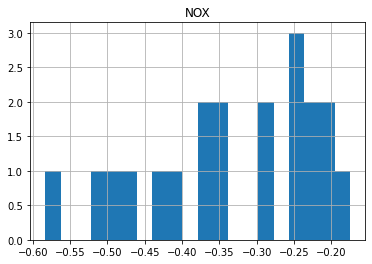

In [12]:
im=W.hist('NOX',bins=20)

## Text explainer using the newsgroups

In [13]:
# run the text explainer example notebook, up to single explanation
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics

from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 83
Probability(christian) = 0.444
True class: atheism


In [14]:
sp_obj = submodular_pick.SubmodularPick(explainer, newsgroups_test.data, c.predict_proba, sample_size=2, num_features=6,num_exps_desired=2)

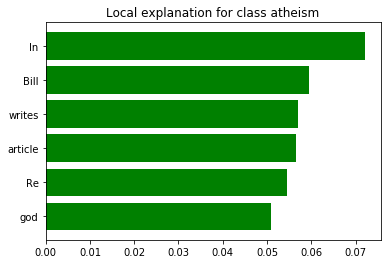

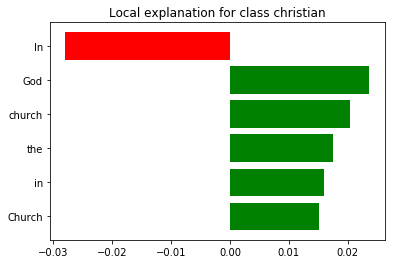

In [ ]:
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [ ]:
from sklearn.datasets import load_iris
iris=load_iris()
from sklearn.model_selection import train_test_split as tts
Xtrain,Xtest,ytrain,ytest=tts(iris.data,iris.target,test_size=.2)
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(Xtrain,ytrain)
rf.score(Xtest,ytest)

/mnt/c/Users/marcotcr/work/lime/python3env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9333333333333333

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(Xtrain, 
                                                   feature_names=iris.feature_names,
                                                   class_names=iris.target_names, 
                                                   verbose=False, 
                                                   mode='classification',
                                                   discretize_continuous=False)

In [ ]:
exp=explainer.explain_instance(Xtrain[i],rf.predict_proba,top_labels=3)
exp.available_labels()

[0, 2, 1]

In [ ]:
sp_obj = submodular_pick.SubmodularPick(
    data=Xtrain,explainer=explainer,num_exps_desired=5,predict_fn=rf.predict_proba, sample_size=20, num_features=4, top_labels=3)

In [ ]:
import pandas as pd
df=pd.DataFrame({})
for this_label in range(3):
    dfl=[]
    for i,exp in enumerate(sp_obj.sp_explanations):
        l=exp.as_list(label=this_label)
        l.append(("exp number",i))
        dfl.append(dict(l))
    dftest=pd.DataFrame(dfl)
    df=df.append(pd.DataFrame(dfl,index=[iris.target_names[this_label] for i in range(len(sp_obj.sp_explanations))]))
df

,exp number,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
setosa,0,-0.410513,-0.049033,-0.003635,0.010532
setosa,1,-0.416660,-0.038774,0.013522,-0.000206
setosa,2,-0.249963,-0.023399,-0.001491,0.000962
setosa,3,-0.423744,-0.053167,0.006401,-0.001301
setosa,4,-0.255049,-0.037626,0.002671,0.002027
versicolor,0,0.254472,-0.042948,0.029553,-0.013252
versicolor,1,0.261545,-0.054880,0.024067,-0.001325
versicolor,2,-0.026307,-0.228508,0.011449,0.008821
versicolor,3,0.282608,-0.034669,0.028875,-0.001872
versicolor,4,-0.009620,-0.164904,-0.015407,-0.008737
